In [20]:
# import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'lightgray'


import warnings
warnings.filterwarnings('ignore')

In [21]:
# loading datasets

df_train_users = pd.read_csv("airbnb-recruiting-new-user-bookings/train_users_2.csv") # training dataset
df_test_users = pd.read_csv("airbnb-recruiting-new-user-bookings/test_users.csv") # testing dataset
df_countries = pd.read_csv("airbnb-recruiting-new-user-bookings/countries.csv")
df_age_gender = pd.read_csv('airbnb-recruiting-new-user-bookings/age_gender_bkts.csv')
df_sessions = pd.read_csv('airbnb-recruiting-new-user-bookings/sessions.csv')

# df_train_users.shape, df_test_users.shape, df_countries.shape, df_age_gender.shape, df_sessions.shape
print(f'Training set contains {df_train_users.shape[0]} users, ' 
      + f'and the testing dataset contains {df_test_users.shape[0]}, '
      + f'giving a grand total of {df_train_users.shape[0] + df_test_users.shape[0]} users.')

Training set contains 213451 users, and the testing dataset contains 62096, giving a grand total of 275547 users.


In [ ]:
# combining train and test datasets (Unecessary)
# all_users = pd.concat((df_train_users, df_test_users), axis=0, ignore_index=True)

# all_users.head()

df_train_users.head()

In [ ]:
# [print(f"{col} has {all_users[col].isnull().sum()} null values.", end='\n\n') for col in all_users.columns if all_users[col].isnull().sum() != 0]

[print(f"{col} has {df_train_users[col].isnull().sum()} null values.", end='\n\n') for col in df_train_users.columns if df_train_users[col].isnull().sum() != 0]


In [ ]:
# all_columns = all_users.columns.tolist()
all_columns = df_train_users.columns.tolist()

missing_counts = []
for col in all_columns:
    # count = all_users[col].isnull().sum() + all_users[col].eq('-unknown-').sum()
    count = df_train_users[col].isnull().sum() + df_train_users[col].eq('-unknown-').sum()
    if count > 0:
        missing_counts.append((col, count))

if missing_counts:
    missing_counts = pd.DataFrame(missing_counts, columns=['column', 'count'])

    plt.figure(figsize=(12, 6))
    plt.bar(missing_counts['column'], missing_counts['count'])
    plt.xticks(rotation=45)
    plt.xlabel('Column')
    plt.ylabel('Count')
    plt.title('Missing Values per Column')
    plt.show()
else:
    print("No columns with missing values found.")

Each of these columns and their missing or incompatible data needs to be addressed. Lets start with Gender!

In [ ]:
# all_users.gender.value_counts()
df_train_users.gender.value_counts()

In [ ]:
# all_users.gender.replace('-unknown-', np.nan, inplace=True)
# print(all_users.gender.value_counts())

df_train_users.gender.replace('-unknown-', np.nan, inplace=True)
print(df_train_users.gender.value_counts())

plt.figure(figsize=(12, 6))
# all_users.gender.value_counts().plot(kind='bar')
df_train_users.gender.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.xlabel('Column')
plt.ylabel('Count')
plt.title('Gender of Users')
plt.show()

#### Entropy of OTHER gender?

In [ ]:
plt.figure(figsize=(10,6))
df_train_users.age.hist(bins=100)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

We need to take care of the outrageously large ages, and with a bit of creative thinking along with the help of this notebook --> https://www.kaggle.com/code/kevinwu06/airbnb-exploratory-analysis/notebook, I will assume that the very large ages should represent birth years instead. This gives us more data to work with.

Using 2010 as the reference year, as noted in the Airbnb Dataset Description, I changed the values of our users to be in a valid range of 16 to 100. Large values were converted from "birth years" to an appropriate age, and values below 16 and above 100 were changed to NaN.

In [ ]:
ages = df_train_users['age'].copy()

ref_year = 2010 # "...users dataset dates back to 2010."
ages[(ages >= 1910) & (ages <= 1994)] = ref_year - ages[(ages >= 1910) & (ages <= 1994)]
ages[(ages < 16) | (ages > 100)] = np.nan

plt.figure(figsize=(10,6))
ages.hist(bins=100)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

print(ages.describe())

# replacing orginal age column with cleaned age column
df_train_users['age'] = ages

### optional idea for missing age data, look into predictive imputation

In [ ]:
middle_age = 36

plt.figure(figsize=(20,12))
bar_width = 0.35

young_travelers = sum(df_train_users.loc[df_train_users['age'] < middle_age, 'country_destination'].value_counts())
old_travelers = sum(df_train_users.loc[df_train_users['age'] > middle_age, 'country_destination'].value_counts())

young_dest = df_train_users.loc[df_train_users['age'] < middle_age, 'country_destination'].value_counts() / young_travelers * 100
old_dest = df_train_users.loc[df_train_users['age'] > middle_age, 'country_destination'].value_counts() / old_travelers * 100

young_dest.plot(kind='bar', width=bar_width, position=0, label='Young Travelers', color='#009E73')
old_dest.plot(kind='bar', width=bar_width, position=1, label='Older Travelers', color='#CC79A7')


plt.legend()
plt.title('Older vs. Younger Country Destination Percentages')
plt.xlabel('Destination Country')
x_ticks = range(len(young_dest.index))
plt.xticks(rotation=45)
plt.ylabel('Percentage')
plt.subplots_adjust(bottom=0.2)
plt.show()

### K-Means

In [22]:
df_train_users.drop(columns='id', inplace=True)

print(df_train_users.isnull().sum())

date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64


In [23]:
print(f'date_first_booking has {(df_train_users.date_first_booking.isnull().sum()/len(df_train_users))*100}% missing values')
print(f'age has {(df_train_users.age.isnull().sum()/len(df_train_users))*100}% missing values')
print(f'first_affiliate_tracked has {(df_train_users.first_affiliate_tracked.isnull().sum()/len(df_train_users))*100}% missing values')

date_first_booking has 58.34734904029496% missing values
age has 41.222575673105304% missing values
first_affiliate_tracked has 2.84140153946339% missing values


In [24]:
for col in df_train_users.columns:
    print(df_train_users[col].value_counts())

date_account_created
2014-05-13    674
2014-06-24    670
2014-06-25    636
2014-05-20    632
2014-05-14    622
             ... 
2010-03-09      1
2010-01-28      1
2010-01-31      1
2010-04-11      1
2010-06-18      1
Name: count, Length: 1634, dtype: int64
timestamp_first_active
20090319043255    1
20140115183807    1
20140115225909    1
20140115230241    1
20140115230335    1
                 ..
20130415234245    1
20130415234440    1
20130415234724    1
20130415235636    1
20140630235824    1
Name: count, Length: 213451, dtype: int64
date_first_booking
2014-05-22    248
2014-06-11    231
2014-06-24    226
2014-05-21    225
2014-06-10    223
             ... 
2010-01-31      1
2010-02-09      1
2010-06-10      1
2010-02-04      1
2015-06-28      1
Name: count, Length: 1976, dtype: int64
gender
-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: count, dtype: int64
age
30.0      6124
31.0      6016
29.0      5963
28.0      5939
32.0      5855
          .

predictive imputation for missing age data

In [25]:
from sklearn.linear_model import LinearRegression

df_process = df_train_users[['age', 'gender', 'signup_method', 'timestamp_first_active']].copy()
current_year = 2014


def preprocess_data(df):
    def correct_age(age):
        if age > 1000:
            return current_year - age
        elif age > 110:
            return 0
        return age
    
    df['age'] = df['age'].apply(correct_age)
    
    df['timestamp_first_active'] = pd.to_datetime(df['timestamp_first_active'], format='%Y%m%d%H%M%S')
    
    df['year_first_active'] = df['timestamp_first_active'].dt.year
    df['month_first_active'] = df['timestamp_first_active'].dt.month
    df['day_first_active'] = df['timestamp_first_active'].dt.day
    df['hour_first_active'] = df['timestamp_first_active'].dt.hour
    
    df.drop('timestamp_first_active', axis=1, inplace=True)
    
    categorical_features = ['gender', 'signup_method']
    df_categorical = pd.get_dummies(df[categorical_features], drop_first=True)
    
    df_processed = pd.concat([df[['year_first_active', 'month_first_active', 'day_first_active', 'hour_first_active']], df_categorical], axis=1)
    
    if 'age' in df.columns:
        df_processed['age'] = df['age']
    
    return df_processed

df_processed = preprocess_data(df_process)

# print(df_processed.columns)

train_data = df_processed[df_processed['age'].notnull()]
predict_data = df_processed[df_processed['age'].isnull()]

regressor = LinearRegression()
regressor.fit(train_data.drop('age', axis=1), train_data['age'])

predicted_ages = regressor.predict(predict_data.drop('age', axis=1))

predicted_ages_rounded = np.round(predicted_ages).astype(int)

df_process.loc[df_process['age'].isnull(), 'age'] = predicted_ages_rounded

# value_counts_corrected = df_process['age'].value_counts().sort_index()
# print(value_counts_corrected)

df_train_users['age'] = df_process['age']
print(f'age has {(df_train_users.age.isnull().sum()/len(df_train_users))*100}% missing values')

age has 0.0% missing values


In [26]:
gender_code = df_train_users['gender'].copy()

# replace gender categories with numeric codes
def gender_mapping(gender):
    if gender == 'MALE':
        return 0
    elif gender == 'FEMALE':
        return 1
    elif gender == 'OTHER':
        return 2
    else:
        return 4
    
# apply mapping
gender_code = gender_code.apply(gender_mapping)

# verify changes
print(gender_code.value_counts())

# overwrite column
df_train_users['gender'] = gender_code

gender
4    95688
1    63041
0    54440
2      282
Name: count, dtype: int64


#### Handling missing values for first_affiliate_tracked column
changed NaN to untracked

In [27]:
df_train_users['first_affiliate_tracked'].fillna('untracked', inplace=True)

#### At this point, date_first_booking is the only column with missing data, and because it is missing such a large portion (nearly 60%), I think the best decision is to not include it in the training of the K-Means algorithm.

In [28]:
df_train_users['date_account_created'] = pd.to_datetime(df_train_users['date_account_created'])
df_train_users['date_first_booking'] = pd.to_datetime(df_train_users['date_first_booking'])

df_train_users.drop(columns='date_first_booking', inplace=True)

df_train_users.dtypes

date_account_created       datetime64[ns]
timestamp_first_active              int64
gender                              int64
age                               float64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

#### encoding

In [29]:
categorical_features = df_train_users.select_dtypes(include='object').columns

df_encoded = pd.get_dummies(df_train_users, columns=categorical_features, drop_first=True)
df_encoded.info()

df_encoded.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Columns: 134 entries, date_account_created to country_destination_other
dtypes: bool(129), datetime64[ns](1), float64(1), int64(3)
memory usage: 34.4 MB


date_account_created         datetime64[ns]
timestamp_first_active                int64
gender                                int64
age                                 float64
signup_flow                           int64
                                  ...      
country_destination_NDF                bool
country_destination_NL                 bool
country_destination_PT                 bool
country_destination_US                 bool
country_destination_other              bool
Length: 134, dtype: object

In [30]:
# extract numerical features for date_account_created
df_encoded['dac_year'] =df_encoded['date_account_created'].dt.year
df_encoded['dac_month'] =df_encoded['date_account_created'].dt.month
df_encoded['dac_day'] = df_encoded['date_account_created'].dt.day
# df_encoded['dfb_year'] =df_encoded['date_first_booking'].dt.year
# df_encoded['dfb_month'] =df_encoded['date_first_booking'].dt.month
# df_encoded['dfb_day'] = df_encoded['date_first_booking'].dt.day

# drop
df_encoded.drop(['date_account_created'], axis=1, inplace=True)


#### scale

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)

#### dimensionality reduction

In [32]:
from sklearn.decomposition import PCA

pca = PCA(0.95)
df_pca = pca.fit_transform(df_scaled)

download joblib for parallelization! otherwise, running this cell will be long than 39 minutes. This ran for 39 minutes at 100% CPU utilization.

In [33]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed

# Function to fit MiniBatchKMeans and compute silhouette score
def compute_silhouette(df_pca, k):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=716, batch_size=1000)
    kmeans.fit(df_pca)
    score = silhouette_score(df_pca, kmeans.labels_)
    print(f"For k={k}, silhouette score: {score}")
    return score

# List of k values to evaluate
k_values = range(2, 11)

# Parallel computation using joblib
silhouette_scores = Parallel(n_jobs=-1)(delayed(compute_silhouette)(df_pca, k) for k in k_values)

# Print silhouette scores
for k, score in zip(k_values, silhouette_scores):
    print(f"For k={k}, silhouette score: {score}")

For k=2, silhouette score: 0.13795305175225173
For k=3, silhouette score: 0.1363189492134608
For k=4, silhouette score: 0.15690540243320866
For k=5, silhouette score: 0.013514125906811765
For k=6, silhouette score: 0.04313903039296689
For k=7, silhouette score: 0.08577328050512394
For k=8, silhouette score: 0.13915152538761394
For k=9, silhouette score: 0.049934701738750385
For k=10, silhouette score: 0.08178290285558168


In [34]:
def fit_kmeans(df_pca, k):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=716, batch_size=5000)
    kmeans.fit(df_pca)
    return kmeans

optimal_k = 4

# n_jobs=-1 uses all CPU cores available
kmeans_model = Parallel(n_jobs=-1)(delayed(fit_kmeans)(df_pca, optimal_k) for _ in range(1))[0] 

print("Fitted MiniBatchKMeans model:", kmeans_model)

Fitted MiniBatchKMeans model: MiniBatchKMeans(batch_size=5000, n_clusters=4, random_state=716)


In [35]:
# cluster centers
cluster_centers = kmeans_model.cluster_centers_

# cluster labels
cluster_labels = kmeans_model.labels_

df_train_users['cluster_label'] = cluster_labels

#### visualize clusters

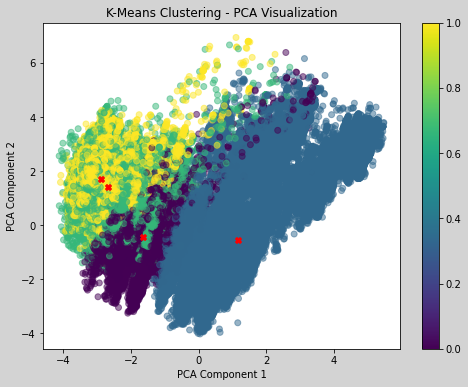

In [36]:
# Visualize clusters in PCA space
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5, label='Data points')
plt.scatter(cluster_centers[:,0], cluster_centers[:,1], c='red', marker='X', label='Cluster Centers')
plt.title('K-Means Clustering - PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

#### cluster analysis